<a href="https://colab.research.google.com/github/05-515/stepik_deep_learning_2025_2/blob/main/6_%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_%D0%A1%D0%BA%D1%80%D0%B8%D0%BD%D0%BA%D0%B0%D1%81%D1%82_1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение char-level языковой модели с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [ ]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


gazeta_train.jsonl:   0%|          | 0.00/471M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [ ]:
dataset['validation']['text'][0]

'После громких приобретений Андре Шюррле, Гуса Тиля, Эсекьеля Понсе и Джордана Ларссона , а также покупки Резиуана Мирзова московский «Спартак» не планирует закрывать свою летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. Особенно актуальным данный вопрос стал после ухода бразильского хавбека Фернадо в китайский «Бэйцзин Гоань». Тепень за оборонительные действия в «Спартаке» отвечают Роман Зобнин и Аяз Гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции. Nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech Ceskou republiku. I pri veskerem fotbalem respektu k vyznamu tohoto slavneho klubu Slavia odmitla vubec zahajit i zdvorilostni jednani o obou transferech. Ani jeden nyni neni na prodej. После 

In [ ]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [ ]:
sentences[:10]

['красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны.',
 'особенно актуальным данный вопрос стал после ухода бразильского хавбека фернадо в китайский «бэйцзин гоань».',
 'nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech ceskou republiku.',
 'ani jeden nyni neni na prodej.',
 'кроме спортивного директора москвичей томаса цорна.',
 'позднее же французские журналисты назвали другого возможного новичка москвичей, а именно опорника «ниццы» адриена тамеза.',
 'именно при знаменитом в прошлом футболисте тамез закрепился в основном составе «орлов».',
 'учитывая это, со своим ключевым игроком «ницца» и виейра в частности не торопятся.',
 'свою профессиональную карьеру французский полузащитник начал в «нанси», выпускником клубной академии которого он и является.',
 'однако по окончании сезона-2017/18 фавр был вынужден покинуть «ниццу», возглавив впоследствии дортмундскую «боруссию».']

In [ ]:
len(sentences)

122237

In [ ]:
chars = Counter()#частота встречаемости

for sentence in tqdm(sentences):
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])#pad делать тензоры в тренировочных бачах прямоуголной формы. у коротких примеров ббулем добавлять pad, для выравниывния батчей
counter_threshold = 500 #в словарь символы,которые встречаются чаще, чем 500 раз. можно экспериментировать с этим значением

for char, cnt in chars.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [ ]:
len(vocab)

86

In [ ]:
char2ind = {char: i for i, char in enumerate(vocab)}#конвертируем буквы в индексы и обратно
ind2char = {i: char for char, i in char2ind.items()}

In [ ]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:#возвращает токенизированную последовательность, падинги не делаеми еще,не знаем длину наших предложений
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]#если неизвестный символ,то просто возвращает unk_id
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
#делает падинги до самой длинной последовательности в этом батче,потом из него делает torch.Tensor и перемещает на девайс
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {  #состоит из входной последовательности и target то, что хотим предсказывать
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:] # просто небходимо сдвинуть все токены на единицу вправо, это и будет наша таргет
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

In [ ]:
eval_sentences[0]

'по его словам, это урегулирование судебных споров.'

## Архитектура модели

In [ ]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)#по индексу сопостовляет некоторый вектор. подаем количество наших букв
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)#можно использовать ванильный RNN и LSTM
        self.linear = nn.Linear(hidden_dim, hidden_dim)#просто для дополнительного преобразования
        self.projection = nn.Linear(hidden_dim, vocab_size)# линейный слой, который будет отображать наши скрытые состояния в размер словаря. на основе этого слоя будем делать предсказание о следующем токене

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)#для стабилизации нашего обучения

    def forward(self, input_batch) -> torch.Tensor:# получаем входной батч индексов
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]#прогоняем через RNN
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]# применим линейную функцию и линейный слой для некоторого преобразования и в конце dropout
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

## Train loop

In [ ]:
def evaluate(model, criterion) -> float: #вычисляет перплексию на некотором валидационном множестве.
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, #логиты предсказаний
                batch['target_ids'].flatten()
                )
            perplexity.append(torch.exp(loss).item())# хитросмть, воспользуемся функцией кросс-энтропии(лосс). это почти одно и тоже

    perplexity = sum(perplexity) / len(perplexity) #просто посчитаем среднее

    return perplexity

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])#говорим, что по этому индексу pad не нужно считать loss
optimizer = torch.optim.Adam(model.parameters())#используем стандартный adam

In [ ]:
num_epoch = 10#для эксперимента можно сделать больше
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/382 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/382 [00:00<?, ?it/s]

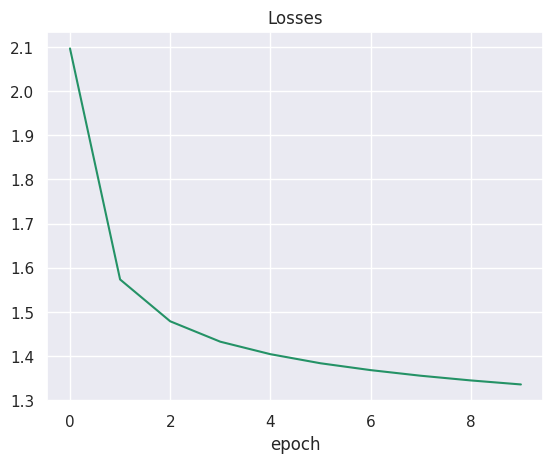

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

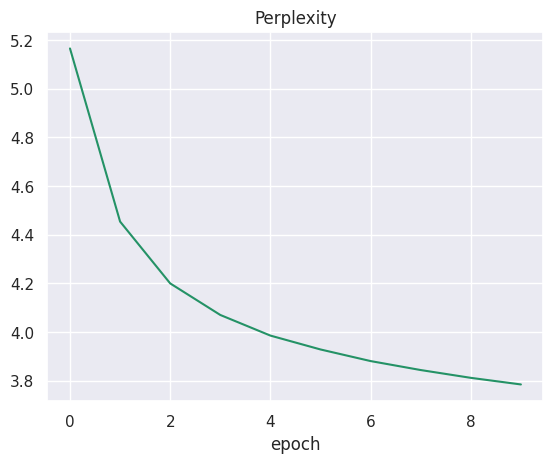

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Generation

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == char2ind['<eos>']:
                break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])#преобразуем в индексы в буквы

    return words

In [ ]:
generate_sequence(model, starting_seq='напишу ерунду ') #скорее всего  мы не дообучили модель еще и труьбеуется еще больше данных.

'<bos>напишу ерунду подобные политика по статье 2019 года в своем трампом под странами в своем транспортном соглашении совета по статье 2019 года.<eos>'